# ***Поиск фотографий по текстовому описанию***

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## 1. Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 2. Подготовка среды

In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from math import sqrt
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Параметры и конфигурации для восроизводимости
RANDOM_STATE = 0
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(mode=True)
# Константы
TEST_SIZE = 0.3 # Относительная величина валидационных выборок
PATH = './dataset/to_upload/'   # Путь к данным
TRAIN_IMG_DIR = 'train_images/' # Папка с тренировочными изображениями
TEST_IMG_DIR = 'test_images/'   # Папка с тестовыми изображениями
n_samples = 3 # Величина случайных выборок для визуализации данных
warnings.simplefilter('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Скачать файл по ссылке
if not os.path.isfile("./dataset.zip"):
    !wget -q "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip" -O "./dataset.zip"
if not os.path.isdir(PATH):
    !unzip -q -n "./dataset.zip" -d "./dataset"

In [4]:
os.listdir(PATH)

['train_dataset.csv',
 'test_queries.csv',
 'ExpertAnnotations.tsv',
 'test_images.csv',
 '.DS_Store',
 'test_images',
 'train_images',
 'CrowdAnnotations.tsv']

## 3. Знакомство с данными

Загрузим и взглянем на тренировочные данные.

In [5]:
# Посмотрим на файл с описаниями
train_dataset_df = pd.read_csv(PATH + 'train_dataset.csv')
train_dataset_df.info()
train_dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


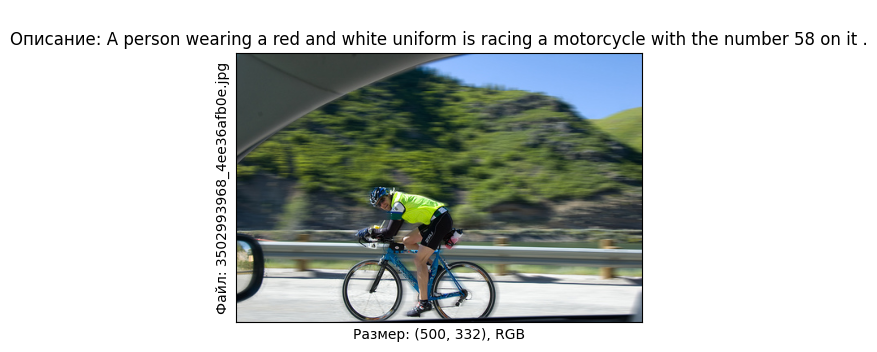

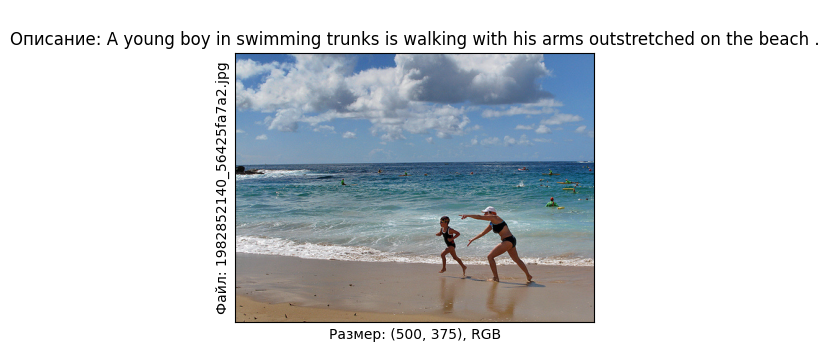

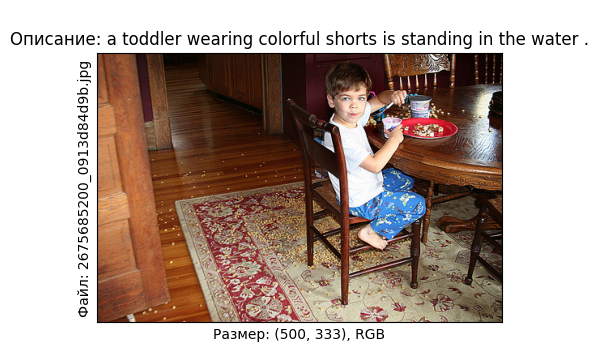

In [47]:
# Ознакомимся с тренировочными изображениями
imgs = train_dataset_df.sample(n=n_samples, random_state=RANDOM_STATE)
for i, img in enumerate(imgs['image']):
    fig = plt.figure(figsize=(7, 3.5))
    image = Image.open(PATH + TRAIN_IMG_DIR + img)
    plt.imshow(image)
    plt.title(f'\nОписание: {imgs["query_text"].iloc[i]}')
    plt.xlabel(f'Размер: {image.size}, {image.mode}')
    plt.ylabel(f'Файл: {img}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

Ознакомимся с данными о краудсорсинговых оценках.

In [7]:
crowd_annotations_df = pd.read_csv(
    PATH + 'CrowdAnnotations.tsv',
    sep='\t',
    names= train_dataset_df.columns[:-1].tolist() + ['crowd_annotations_rate',
                                                     'crowd_annotations_1',
                                                     'crowd_annotations_0']
)
crowd_annotations_df.info()
crowd_annotations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   47830 non-null  object 
 1   query_id                47830 non-null  object 
 2   crowd_annotations_rate  47830 non-null  float64
 3   crowd_annotations_1     47830 non-null  int64  
 4   crowd_annotations_0     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,crowd_annotations_rate,crowd_annotations_1,crowd_annotations_0
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Ознакомимся с данными об экспертных оценках.

In [8]:
expert_annotations_df = pd.read_csv(
    PATH + 'ExpertAnnotations.tsv',
    sep='\t',
    names= train_dataset_df.columns[:-1].tolist() + ['expert_1',
                                                     'expert_2',
                                                     'expert_3']
)
expert_annotations_df.info()
expert_annotations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Взглянем на тестовые данные.

In [9]:
test_queries_df = pd.read_csv(
    PATH + 'test_queries.csv',
    sep='|', on_bad_lines='warn'
)
test_queries_df.info()
test_queries_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


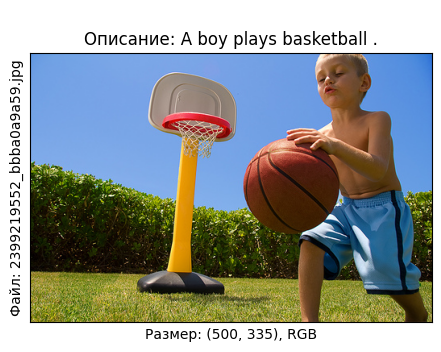

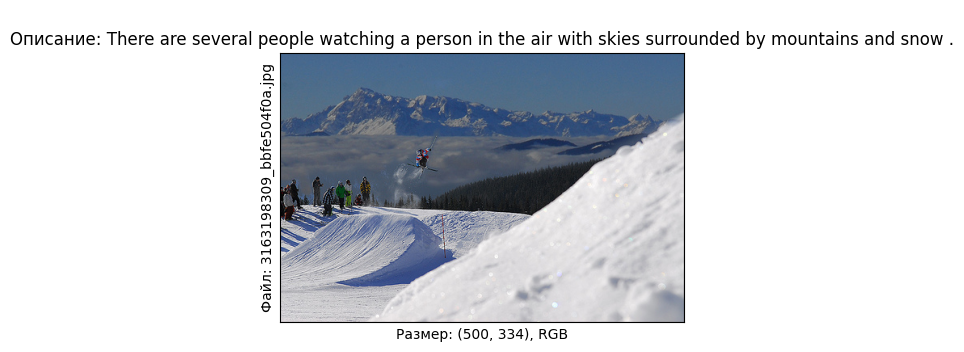

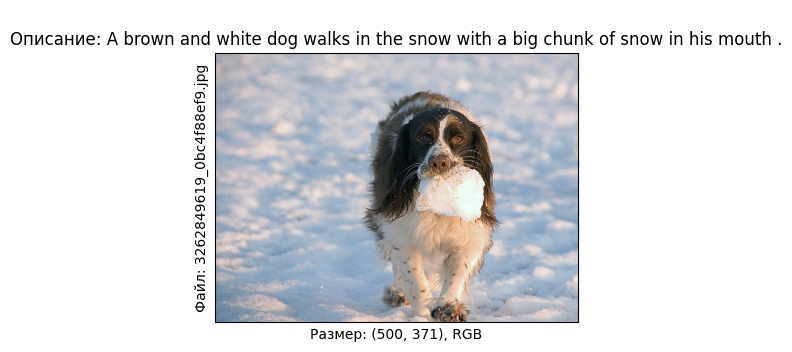

In [48]:
# Ознакомимся с тестовыми изображениями
imgs = test_queries_df.sample(n=n_samples, random_state=RANDOM_STATE)
for i, img in enumerate(imgs['image']):
    fig = plt.figure(figsize=(7, 3.5))
    image = Image.open(PATH + TEST_IMG_DIR + img)
    plt.imshow(image)
    plt.title(f'\nОписание: {imgs["query_text"].iloc[i]}')
    plt.xlabel(f'Размер: {image.size}, {image.mode}')
    plt.ylabel(f'Файл: {img}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

Итак, данные не содержат пропусков и в целом соответствуют описанию.

## 4. Предобработка и анализ данных

Из тестовых данных удалим дублирующую индекс колонку `Unnamed: 0`.

In [11]:
test_queries_df = test_queries_df.drop(columns=['Unnamed: 0'])

Объединим таблицы с тренировочными данными.

In [12]:
train_df = train_dataset_df.merge(expert_annotations_df, how='left', on=['image', 'query_id'])  \
                           .merge(crowd_annotations_df, how='left', on=['image', 'query_id'])
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   5822 non-null   object 
 1   query_id                5822 non-null   object 
 2   query_text              5822 non-null   object 
 3   expert_1                5822 non-null   int64  
 4   expert_2                5822 non-null   int64  
 5   expert_3                5822 non-null   int64  
 6   crowd_annotations_rate  2329 non-null   float64
 7   crowd_annotations_1     2329 non-null   float64
 8   crowd_annotations_0     2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 409.5+ KB


,image,query_id,query_text,expert_1,expert_2,expert_3,crowd_annotations_rate,crowd_annotations_1,crowd_annotations_0
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,1.0,3.0,0.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN


Создадим единую оценку соответствия текстов и изображений на основе экспертных и краудсорсинговых оценок. Для этого возьмем среднюю оценку от экспертов и приведем ее к диапазону [0, 1]. Далее, сложим оценку экспертов с коэффициентом 0.6, а крауда (доля исполнителей, подтвердивших, что текст соответствует картинке) — с коэффициентом 0.4. В случае отсутствия оценок крауда применим только экспертные оценки с коэффициентом 1.

In [13]:
# Функция объединения оценок
def combine_rates(df):
  expert_rate = (df['expert_1'] + df['expert_2'] + df['expert_3'] - 3) / 9
  if pd.isna(df['crowd_annotations_rate']):
    return expert_rate
  else:
    return 0.6 * expert_rate + 0.4 * df['crowd_annotations_rate']

In [14]:
# Создание колонки с единой оценкой
train_df['target'] = train_df.apply(combine_rates, axis=1)
# Удаление исходных оценок из датафрейма
train_df = train_df.drop(columns=['expert_1',
                                  'expert_2',
                                  'expert_3',
                                  'crowd_annotations_rate',
                                  'crowd_annotations_1',
                                  'crowd_annotations_0'])
train_df.head()

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.133333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


Исследуем распределение полученных оценок.

count    5822.000000
mean        0.183138
std         0.247178
min         0.000000
25%         0.000000
50%         0.111111
75%         0.222222
max         1.000000
Name: target, dtype: float64


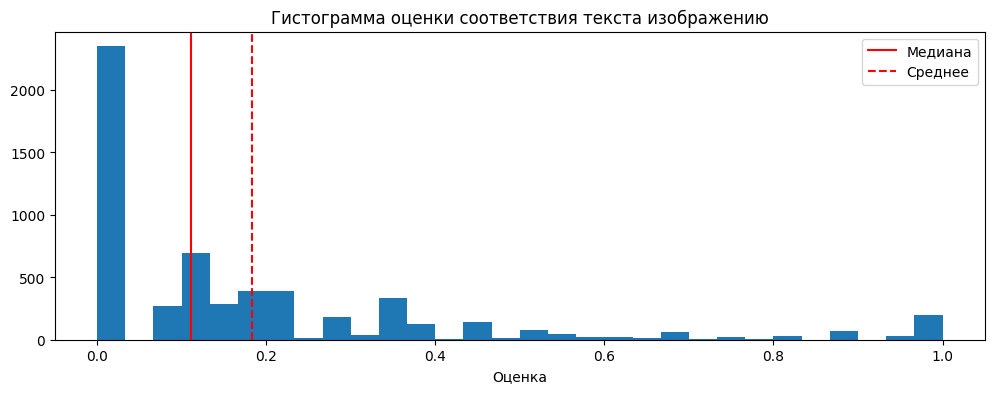

In [15]:
print(train_df['target'].describe())

fig, ax = plt.subplots(figsize=(12, 4));
plt.hist(train_df['target'], bins=30);
plt.axvline(x=train_df['target'].median(), color='red', label='Медиана');
plt.axvline(x=train_df['target'].mean(), color='red', label='Среднее', linestyle='--');
plt.legend()
plt.title(f'Гистограмма оценки соответствия текста изображению')
plt.xlabel('Оценка')
plt.show();

Распределение оценок сильно смещено влево, средняя оценка - 0.18. В датасете преобладают примеры несоответствия либо слабого соответствия описаний и изображений.

## 5. Проверка данных

В некоторых странах, где работают сервисы заказчика, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет. Все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим функцию для удаления из датафрейма данных с упоминаниями детей.

In [16]:
def remove_restricted_data(data, verbose=True):
    df = data.copy()
    # Создаем список слов-исключений
    restricted_words = ['baby', 'babies', 'children', "child",
                        'boy', 'girl', 'teen', "kid", "teenager",
                        "minor", "adolescent", "youngster", "schoolboy", "schoolgirl", "youth"]
    for word in restricted_words[4:]:
        restricted_words.append(word + 's')

    # Создаем регулярное выражение: \b(word1|word2|word3)\b
    pattern = r'\b(' + '|'.join(map(re.escape, restricted_words)) + r')\b'

    # Проверяем совпадения
    mask = df['query_text'].str.contains(pattern, case=False, regex=True, na=False)
    if verbose:
        print('Количество строк с неприемлемым контентом:', sum(mask))

    approved_data = df[~mask].reset_index(drop=True)
    removed_data = df[mask]

    return approved_data, removed_data

Удалим юридически неприемлемый контент из тренировочных данных..

In [17]:
train_df, removed_data = remove_restricted_data(train_df)

Количество строк с неприемлемым контентом: 1548


In [18]:
print(f'Выборка из {n_samples} удаленных строк:')
for text in removed_data.sample(n=n_samples, random_state=RANDOM_STATE)['query_text']:
    print(text)

Выборка из 3 удаленных строк:
A little girl wearing sunglasses puts her feet into the kitchen sink .
Two woman in colorful costumes look at a little girl wearing a brown vest .
A group of people with their backs to the camera and a little girl facing a lady .


## 6. Векторизация признаков

Создадим модель для эмбеддинга текстов. Для этого используем популярную трансформерную модель из хаба Huggingface для задачи извлечения признаков из текстов (BAAI/bge-large-en-v1.5). Напишем функцию для создания эмбеддингов текстов.

In [19]:
MODEL_NAME = "BAAI/bge-large-en-v1.5"

text_embedder = SentenceTransformer(MODEL_NAME, device=device)
text_embedder.max_seq_length = 512

def embed_texts(text_embedder, data, batch_size=128):
    """Batch-process texts with automatic normalization"""
    df = data.copy()
    embeds = text_embedder.encode(
        df["query_text"].tolist(),
        batch_size=batch_size,
        convert_to_tensor=True,
        device=device
    ).cpu()

    df["text_embeds"] = list(embeds)
    return df

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Создадим эмбеддинги текстов тренировочной выборки.

In [20]:
train_df = embed_texts(text_embedder, train_df)
print('Размерность эмбеддинга текстового описания:', train_df["text_embeds"][0].size())

Размерность эмбеддинга текстового описания: torch.Size([1024])


Далее, создадим модель для создания эмбеддингов изображений. Для этого будем использовать предобученную модель ResNet50.

In [21]:
resnet = models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


In [22]:
# "Заморозим" параметры модели
for param in resnet.parameters():
    param.requires_grad_(False)

In [23]:
# Проверяем количество обучаемых параметров
trainable_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in resnet.parameters())
print(f"Обучаемые параметры: {trainable_params} ({trainable_params/total_params:.2%} от общего числа {total_params})")

Обучаемые параметры: 0 (0.00% от общего числа 25557032)


In [24]:
print(list(resnet.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

Для создания эмбеддингов будем использовать все слои модели кроме последнего.

In [25]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device)

# Определяем модель для создания эмбеддингов изображений
img_embedder = resnet.eval()

Подготовим класс для нормализации изображений.

In [26]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

Определим функцию для создания эмбеддингов изображений.

In [27]:
def embed_imgs(img_embedder, data, img_path=TRAIN_IMG_DIR):
    df = data.copy()
    img_embeds = []

    for img_file in df['image']:
      img = Image.open(PATH + img_path + img_file).convert('RGB')
      image_tensor = preprocess(img)
      output_tensor = resnet(image_tensor.resize_(1, 3, 224, 224).to(device)).flatten()
      img_embeds.append(output_tensor.cpu())

    df['img_embeds'] = img_embeds
    return df


Создадим эмбеддинги тренировочных изображений.

In [28]:
train_df = embed_imgs(img_embedder, train_df)
print('Размерность эмбеддинга изображения:', train_df['img_embeds'][0].size())

Размерность эмбеддинга изображения: torch.Size([2048])


## 7. Обучение модели предсказания соответствия

Будем работать с фрэймворком `pytorch`. Создадим и обучим модели линейной регрессии и полносвязных нейронных сетей. По сути, мы имеем дело с задачей регрессии, поэтому для оценки моделей будет разумно использовать метрику R2. В дополнение к этому, будем отслеживать метрику MAE. Для более адекватного сравнения моделей перед подсчетом метрик применим к предсказаниям линейной регрессии функцию сигмоиды (та же функция будет применена к выходному нейрону нейронной сети).

Зададим гипараметры обучения моделей.

In [29]:
batch_size = 16
num_epochs = 50
patience = 5 # Сколько эпох ждать улучшения метрики до прерывания обучения модели
input_size = train_df['img_embeds'][0].shape[0] + train_df['text_embeds'][0].shape[0]
n_splits = 3 # Количество шагов кроссвалидации

Подготовим тренировочную выборку для обучения моделей.

In [30]:
# Создаем тензоры статистик для нормализации данных
mean_txt = torch.stack(train_df['text_embeds'].tolist()).mean(dim=0)
std_txt = torch.stack(train_df['text_embeds'].tolist()).std(dim=0)
mean_img = torch.stack(train_df['img_embeds'].tolist()).mean(dim=0)
std_img = torch.stack(train_df['img_embeds'].tolist()).std(dim=0)

# Создаем transform для нормализации данных
class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return (x - self.mean) / self.std

In [31]:
# создадим класс, преобразующий наш DataFrame в Dataset
class Dataframe_to_Dataset(Dataset):
    def __init__(self, df, transform_txt=None,transform_img=None, train=True):
        self.df = df
        self.transform_txt = transform_txt
        self.transform_img = transform_img
        self.train = train
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]
        if self.transform_txt and self.transform_img:
            features = torch.cat((self.transform_txt(row['text_embeds']), self.transform_img(row['img_embeds'])))
        else:
            features = torch.cat((row['text_embeds'], row['img_embeds']))
        if self.train:
            target = row['target']
            return features.type('torch.FloatTensor'), torch.tensor(target).type('torch.FloatTensor')
        else:
            return features.type('torch.FloatTensor')

Определим функцию, принимающую на вход исходный датафрейм, индексы тренировочной и валидационной выборок и возвращающую загрузчики (Dataloader) тренировочной и валидационной выборок.

In [32]:
def load_data(dataframe, train_indices, val_indices=None, train=True):
    df = dataframe.copy()
    if train:
        columns = ['text_embeds', 'img_embeds', 'target']
    else:
        columns = ['text_embeds', 'img_embeds']
    df_train = df.loc[train_indices]
    if val_indices is not None:
        df_val = df.loc[val_indices]
    else:
        df_val = None
    # инициализируем тренировочный и валидационный датасеты, нормализуем признаки
    train_dataset = Dataframe_to_Dataset(
        df_train[columns],
        transform_txt=lambda x: Normalize(mean_txt, std_txt)(x),
        transform_img=lambda x: Normalize(mean_img, std_img)(x),
        train=train
        )
    if df_val is not None:
        val_dataset = Dataframe_to_Dataset(
            df_val[columns],
            transform_txt=lambda x: Normalize(mean_txt, std_txt)(x),
            transform_img=lambda x: Normalize(mean_img, std_img)(x),
            train=train
            )
    else:
        val_dataset = None
    # обернем данные в DataLoader
    train_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             drop_last=True,
                             shuffle=train)
    if val_dataset is not None:
        val_loader = DataLoader(dataset=val_dataset,
                                 batch_size=batch_size,
                                 drop_last=True,
                                 shuffle=False)
    else:
        val_loader = None

    return train_loader, val_loader

Создадим класс для прерывания обучения по результатам мониторинга метрики.

In [33]:
class EarlyStopping:
    def __init__(self,
                 patience=5,
                 mode='min',
                 delta=0.001,
                 restore_best_weights=True):
        """
        Args:
            patience (int): Сколько эпох ждать после последнего улучшения метрики
            mode (str): 'min' для метрик "меньше - лучше", 'max' в противном случае
            delta (float): минимальное изменение, считающееся улучшением
            restore_best_weights (bool): восстанавливать ли модель к лучшему состоянию
        """
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.restore_best = restore_best_weights
        self.counter = 0
        self.best_score = None
        self.best_score_2 = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, current_score_2, model):
        if self.best_score is None:
            # Инициализация при первом вызове
            self.best_score = current_score
            self.best_score_2 = current_score_2
            self.best_model_state = model.state_dict()
        else:
            if self.mode == 'min':
                improved = current_score < (self.best_score - self.delta)
            elif self.mode == 'max':
                improved = current_score > (self.best_score + self.delta)
            else:
                raise ValueError("Invalid early stopping mode")

            if improved:
                self.best_score = current_score
                self.best_score_2 = current_score_2
                self.counter = 0
                self.best_model_state = model.state_dict()
            else:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')

            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best:
                    print('Restoring best model weights')
                    model.load_state_dict(self.best_model_state)

        return self.early_stop

Зададим архитектуру моделей линейной регрессии.

In [34]:
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

        # Инициализация весов
        nn.init.kaiming_normal_(self.linear.weight)
        nn.init.constant_(self.linear.bias, 0)

    def forward(self, x):
        return self.linear(x)

Зададим архитектуру моделей нейронной сети.

In [35]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_fraction):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_fraction)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.gelu1 = nn.GELU()
        self.fc2 = nn.Linear(hidden_size,  hidden_size)
        self.dropout2 = nn.Dropout(p=dropout_fraction)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.gelu2 = nn.GELU()
        self.fc3 = nn.Linear(hidden_size,  1)
        self.sigmoid = nn.Sigmoid()

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.gelu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.gelu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

Обучим модели на тренировочной выборке с кроссвалидацией и подбором гиперпараметров в циклах.

In [36]:
# Определим функцию сигмоиды для массивов numpy
def np_sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [37]:
# создадим функцию для инициализации и обучения модели
def init_train_model(architecture='nn', # 'nn' - для нейронной сети, 'lr' - для регрессии
                hidden_size=None,
                dropout_fraction=None,
                learning_rate=0.0001,
                train_loader=None,
                val_loader=None,
                num_epochs=num_epochs,
                verbose=True):
    # Инициализация модели
    if architecture=='nn':
        model = NeuralNet(input_size, hidden_size, dropout_fraction)
        model = torch.nn.DataParallel(model)
        model = model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    else:
        model = LinearRegression(input_size)
        model = torch.nn.DataParallel(model)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Создание прерывания
    early_stopper = EarlyStopping(
    patience=patience,
    mode='max' if architecture=='nn' else 'min',
    delta=0.005,
    restore_best_weights=True
)
    # Цикл обучения
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        train_r2 = 0.0
        for i, (_data, target) in enumerate(train_loader):

            # Прямой проход
            target = target.unsqueeze(-1).to(device)
            _data = _data.to(device)
            outputs = model(_data)
            loss = criterion(outputs, target)

            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * _data.size(0)
            train_mae += mean_absolute_error(target.detach().cpu(),
                                             outputs.detach().cpu()) * _data.size(0)
            if architecture=='nn':
                train_r2 += r2_score(target.detach().cpu(),
                                     outputs.detach().cpu()) * _data.size(0)
            else:
                train_r2 += r2_score(target.detach().cpu(),
                                     nn.Sigmoid()(outputs.detach().cpu()).flatten()) * _data.size(0)

        # Валидация
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []

        # Если не предоставлена валидационная выборка, валидация будет производиться на всей тренировочной выборке
        if val_loader is None:
            val_loader = train_loader

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.unsqueeze(-1).to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item() * inputs.size(0)

                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        # Считаем метрики и средние функции потерь
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)
        train_r2 /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        if architecture=='nn':
            val_r2 = r2_score(np.array(all_targets), np.array(all_preds))
            val_mae = mean_absolute_error(np.array(all_targets), np.array(all_preds))
        else:
            val_r2 = r2_score(np.array(all_targets), np_sigmoid(np.array(all_preds)))
            val_mae = mean_absolute_error(np.array(all_targets), np_sigmoid(np.array(all_preds)))
        if verbose:
                print ('Эпоха [{}/{}], train-loss: {:.5f}, train-r2: {:.5f}, val-loss: {:.5f}, val-r2: {:.5f}, val-mae: {:.5f}'
                       .format(epoch+1, num_epochs, train_loss, train_r2, val_loss, val_r2, val_mae))

        # Проверяем условие прерывания обучения
        monitored_metric = val_r2
        monitored_metric_2 = val_mae
        if early_stopper(monitored_metric, monitored_metric_2, model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Финальная проверка, чтобы удостовериться, что вернется модель с лучшими весами
    if early_stopper.restore_best and not early_stopper.early_stop:
        model.load_state_dict(early_stopper.best_model_state)

    return model, early_stopper.best_score, early_stopper.best_score_2

Зададим варианты перебора гиперпараметров моделей для кроссвалидации.

In [38]:
# Гиперпараметры нейронных сетей
nn_train_params = {'hidden_size': [512, input_size],
                   'dropout_fraction': [0., 0.2],
                   'learning_rate': [0.001, 0.0001]}
# Гиперпараметры линейной регрессии
lr_train_params = {'learning_rate': [0.01, 0.001, 0.0001]}

Подберем и обучим модель линейной регрессии.

In [39]:
best_lr_model = None       # Лучшая модель на кроссвалидации
best_lr_metric = -10000      # Лучшая метрика MSE на кроссвалидации
best_lr_metric_2 = 10000    # Лучшая метрика MAE на кроссвалидации
best_lr_params = {}        # Лучшие гиперпараметры на кроссвалидации

# Цикл перебора гиперпараметров с кроссвалидацией

for learning_rate in lr_train_params['learning_rate']:
    print(f'Testing parameter: learning_rate={learning_rate}')

    gss = GroupShuffleSplit(n_splits=n_splits, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    best_metrics = []
    best_metrics_2 = []
    # Цикл кроссвалидации
    for train_indices, val_indices in gss.split(train_df, groups=train_df['image']):
        train_loader, val_loader = load_data(train_df, train_indices, val_indices)
        _, best_score, best_score_2 = init_train_model( architecture='lr',
                                                        hidden_size=None,
                                                        dropout_fraction=None,
                                                        learning_rate=learning_rate,
                                                        train_loader=train_loader,
                                                        val_loader=val_loader)
        best_metrics.append(best_score)
        best_metrics_2.append(best_score_2)
    # Сохраняем лучшие средние значения метрик на кроссвалидации и соответствующие им гиперпараметры
    if sum(best_metrics)/n_splits > best_lr_metric:
        best_lr_metric = sum(best_metrics)/n_splits
        best_lr_metric_2 = sum(best_metrics_2)/n_splits
        best_lr_params['learning_rate'] = learning_rate

# Обучаем модель с лучшими гиперпараметрами
train_loader, _ = load_data(train_df, train_df.index)
best_lr_model, best_lr_score, best_lr_score_2 = init_train_model( architecture='lr',
                                                            train_loader=train_loader,
                                                            val_loader=None,
                                                            **best_lr_params)

Testing parameter: learning_rate=0.01
Эпоха [1/50], train-loss: 17.66693, train-r2: -6.33757, val-loss: 9.77303, val-r2: -3.03527, val-mae: 0.39552
Эпоха [2/50], train-loss: 12.35678, train-r2: -6.42180, val-loss: 14.61781, val-r2: -3.45660, val-mae: 0.42205
Эпоха [3/50], train-loss: 20.72456, train-r2: -6.95965, val-loss: 14.89154, val-r2: -3.67956, val-mae: 0.42863
Эпоха [4/50], train-loss: 19.78992, train-r2: -6.35953, val-loss: 11.37721, val-r2: -3.88198, val-mae: 0.44854
Эпоха [5/50], train-loss: 11.85288, train-r2: -6.30620, val-loss: 8.63042, val-r2: -3.79317, val-mae: 0.44816
EarlyStopping counter: 1/5
Эпоха [6/50], train-loss: 19.75741, train-r2: -6.64562, val-loss: 25.28185, val-r2: -4.53569, val-mae: 0.47361
Эпоха [7/50], train-loss: 29.82704, train-r2: -8.76453, val-loss: 18.66360, val-r2: -3.84904, val-mae: 0.43251
EarlyStopping counter: 1/5
Эпоха [8/50], train-loss: 17.58545, train-r2: -5.72851, val-loss: 11.64305, val-r2: -4.04874, val-mae: 0.45478
EarlyStopping counter:

Подберем и обучим модель нейронной сети.

In [40]:
best_nn_model = None    # Лучшая модель на кроссвалидации
best_nn_metric = -1000  # Лучшая метрика R2 на кроссвалидации
best_nn_metric_2 = 0    # Лучшая метрика MAE на кроссвалидации
best_nn_params = {}     # Лучшие гиперпараметры на кроссвалидации

# Вложенные циклы перебора гиперпараметров с кроссвалидацией
for hidden_size in nn_train_params['hidden_size']:
    for dropout_fraction in nn_train_params['dropout_fraction']:
        for learning_rate in nn_train_params['learning_rate']:
            print(f'Testing parameters: hidden_size={hidden_size}, '
                  f'dropout_fraction={dropout_fraction}, learning_rate={learning_rate}')

            gss = GroupShuffleSplit(n_splits=n_splits, test_size=TEST_SIZE, random_state=RANDOM_STATE)
            best_metrics = []
            best_metrics_2 = []
            # Цикл кроссвалидации
            for train_indices, val_indices in gss.split(train_df, groups=train_df['image']):
                train_loader, val_loader = load_data(train_df, train_indices, val_indices)
                _, best_score, best_score_2 = init_train_model( architecture='nn',
                                                                hidden_size=hidden_size,
                                                                dropout_fraction=dropout_fraction,
                                                                learning_rate=learning_rate,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader)
                best_metrics.append(best_score)
                best_metrics_2.append(best_score_2)
            # Сохраняем лучшие средние значения метрик на кроссвалидации и соответствующие им гиперпараметры
            if sum(best_metrics)/n_splits > best_nn_metric:
                best_nn_metric = sum(best_metrics)/n_splits
                best_nn_metric_2 = sum(best_metrics_2)/n_splits
                best_nn_params['dropout_fraction'] = dropout_fraction
                best_nn_params['hidden_size'] = hidden_size
                best_nn_params['learning_rate'] = learning_rate

# Обучаем модель с лучшими гиперпараметрами
train_loader, _ = load_data(train_df, train_df.index)
best_nn_model, best_nn_score, best_nn_score_2 = init_train_model( architecture='nn',
                                                            train_loader=train_loader,
                                                            val_loader=None,
                                                            **best_nn_params)

Testing parameters: hidden_size=512, dropout_fraction=0.0, learning_rate=0.001
Эпоха [1/50], train-loss: 0.49929, train-r2: -0.31744, val-loss: 0.43380, val-r2: 0.24626, val-mae: 0.16801
Эпоха [2/50], train-loss: 0.40879, train-r2: 0.24908, val-loss: 0.41437, val-r2: 0.33801, val-mae: 0.14341
Эпоха [3/50], train-loss: 0.37787, train-r2: 0.44941, val-loss: 0.41262, val-r2: 0.37313, val-mae: 0.13516
Эпоха [4/50], train-loss: 0.35875, train-r2: 0.57448, val-loss: 0.41585, val-r2: 0.33512, val-mae: 0.13975
EarlyStopping counter: 1/5
Эпоха [5/50], train-loss: 0.34980, train-r2: 0.59574, val-loss: 0.41372, val-r2: 0.35246, val-mae: 0.14068
EarlyStopping counter: 2/5
Эпоха [6/50], train-loss: 0.34302, train-r2: 0.63819, val-loss: 0.41511, val-r2: 0.33402, val-mae: 0.14155
EarlyStopping counter: 3/5
Эпоха [7/50], train-loss: 0.33977, train-r2: 0.70239, val-loss: 0.40799, val-r2: 0.37984, val-mae: 0.13710
Эпоха [8/50], train-loss: 0.33516, train-r2: 0.66849, val-loss: 0.40920, val-r2: 0.40409, 

Выведем результаты лучших моделей на кроссвалидации для обеих архетиктур.

In [41]:
print('Параметры лучшей линейной регрессии на кроссвалидации:', best_lr_params)
print('R2 (после сигмоиды) лучшей линейной регрессии на кроссвалидации:', best_lr_metric)
print('MAE (после сигмоиды) лучшей линейной регрессии на кроссвалидации:', best_lr_metric_2)
print('Параметры лучшей нейронной сети на кроссвалидации:', best_nn_params)
print('R2 лучшей нейронной сети на кроссвалидации:', best_nn_metric)
print('MAE лучшей нейронной сети на кроссвалидации:', best_nn_metric_2)

Параметры лучшей линейной регрессии на кроссвалидации: {'learning_rate': 0.001}
R2 (после сигмоиды) лучшей линейной регрессии на кроссвалидации: -1.645890712738037
MAE (после сигмоиды) лучшей линейной регрессии на кроссвалидации: 0.37758705019950867
Параметры лучшей нейронной сети на кроссвалидации: {'dropout_fraction': 0.0, 'hidden_size': 512, 'learning_rate': 0.001}
R2 лучшей нейронной сети на кроссвалидации: 0.3965013027191162
MAE лучшей нейронной сети на кроссвалидации: 0.135092094540596


По результатам кроссвалидации лучшие значения метрик показала модель нейронной сети с парметрами {{best_nn_params}}, поэтому именно ее мы будем использовать в дальнейшем.

## 8. Тестирование модели

Подготовим тестовые данные.

In [42]:
# Удалим юридически вредный контент
test_df, removed_data = remove_restricted_data(test_queries_df)
# Создадим эмбеддинги изображений
test_df = embed_imgs(img_embedder, test_df, img_path=TEST_IMG_DIR)
test_df = test_df.reset_index(drop=True)

test_df.info()
test_df.head()

Количество строк с неприемлемым контентом: 169
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    331 non-null    object
 1   query_text  331 non-null    object
 2   image       331 non-null    object
 3   img_embeds  331 non-null    object
dtypes: object(4)
memory usage: 10.5+ KB


,query_id,query_text,image,img_embeds
0,123997871_6a9ca987b1.jpg#1,Several female lacrosse players are going afte...,123997871_6a9ca987b1.jpg,"[tensor(0.1887), tensor(0.0061), tensor(0.1460..."
1,123997871_6a9ca987b1.jpg#3,The woman lacrosse player in blue is about to ...,123997871_6a9ca987b1.jpg,"[tensor(0.1887), tensor(0.0061), tensor(0.1460..."
2,123997871_6a9ca987b1.jpg#4,Women play lacrosse .,123997871_6a9ca987b1.jpg,"[tensor(0.1887), tensor(0.0061), tensor(0.1460..."
3,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg,"[tensor(0.0334), tensor(0.), tensor(0.), tenso..."
4,1319634306_816f21677f.jpg#1,A brown dog sits still on a hillside .,1319634306_816f21677f.jpg,"[tensor(0.0334), tensor(0.), tensor(0.), tenso..."


Напишим функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики. Если запрос ведёт на юридически вредный контент, функция выведет дисклеймер.

In [49]:
def test_model(queries_df, model, text_embedder, test_data, drop_last=False, img_path=TEST_IMG_DIR):
    """
    Args:
        queries_df (pd.DataFrame): Выборка из тестового датафрейма, содержащая описания для проверки
        model (nn.Module): Модель для тестирования
        text_embedder: Модель текстового эмбеддинга полученная ранее
        test_data (pd.DataFrame): Датафрейм с тестовыми данными
        drop_last (bool): Нужно ли отбрасывать неполный последний батч
        img_path (str): Путь к папке с тестовыми изображениями
    """
    df = test_data.copy()
    # Цикл перебора описаний
    for query in queries_df.itertuples():

        query_text = query.query_text
        # Проверка на юридически вредный контент
        _, removed_data = remove_restricted_data(pd.DataFrame({'query_text': [query_text]}),
                                                verbose=False)
        if len(removed_data) > 0:
            print(f'----------------------------------------------'
                  f'---------------------------------------------')
            print(f'Query: "{query_text}" \n This image is unavailable in your country '
                  f'in compliance with local laws')
            print(f'----------------------------------------------'
                  f'---------------------------------------------')
            continue

        # Создание эмбеддинга запроса
        query_embed = embed_texts(text_embedder,
                                  pd.DataFrame({'query_text': [query_text]}))['text_embeds'][0]
        # Помещаем эмбеддинг запроса в колонку датафрейма тестовых данных
        # для прогона через модель вместе с эмбеддингами всех тестовых изображений
        df['text_embeds'] = [query_embed for i in range(len(df))]


        # Создание dataloader с тестовыми данными + эмбеддинг запроса
        test_loader, _ = load_data(df, df.index, val_indices=None, train=False)

        # Предсказание соответствия запроса для всех тестовых изображений
        predicted = []
        model.eval()
        with torch.no_grad():
            for _data in test_loader:
                outputs = model(_data.to(device)).cpu()
                predicted.append(outputs)
                batch = _data
            predicted = torch.cat(predicted, dim=0)
            # Находим максимальную предсказанную оценку и ее индекс
            max_value, max_index = torch.max(predicted, dim=0)
        # Выводим запрос и изображение с максимальной предсказанной оценкой
        print('--------------------------------------------------')
        fig = plt.figure(figsize=(7, 3.5))
        image_predicted = Image.open(PATH + img_path + df.loc[int(max_index), 'image'])
        plt.imshow(image_predicted)
        plt.title(f'\nQuery: {query_text}')
        plt.ylabel(f"Оценка: {float(max_value):.4f}")
        plt.xlabel(f"{df['image'].iloc[int(max_index)]}")
        plt.xticks([])
        plt.yticks([])
        plt.show()

Выберем случайные n запросов из тестовых данных и для каждого запроса выведите наиболее релевантное изображение.

In [50]:
test_queries = test_queries_df.sample(n=n, random_state=RANDOM_STATE)
test_queries

,query_id,query_text,image
90,2399219552_bbba0a9a59.jpg#0,A boy plays basketball .,2399219552_bbba0a9a59.jpg
254,3163198309_bbfe504f0a.jpg#4,There are several people watching a person in ...,3163198309_bbfe504f0a.jpg
283,3262849619_0bc4f88ef9.jpg#3,A brown and white dog walks in the snow with a...,3262849619_0bc4f88ef9.jpg
445,572618443_647483ca82.jpg#0,A man and two boys standing in spraying water .,572618443_647483ca82.jpg
461,661749711_6f408dad62.jpg#1,a small shaggy dog plays with a red ball on th...,661749711_6f408dad62.jpg
15,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg
316,3396275223_ee080df8b5.jpg#1,A group of people perform together onstage .,3396275223_ee080df8b5.jpg
489,973827791_467d83986e.jpg#4,I child slides into a wading pool full of wate...,973827791_467d83986e.jpg
159,269650644_059a84ece5.jpg#4,People using an outdoor ice skating rink .,269650644_059a84ece5.jpg
153,2687672606_275169c35d.jpg#3,The lady in the multi-colored shirt has a neck...,2687672606_275169c35d.jpg


-------------------------------------------------------------------------------------------
Query: "A boy plays basketball ." 
 This image is unavailable in your country in compliance with local laws
-------------------------------------------------------------------------------------------
--------------------------------------------------


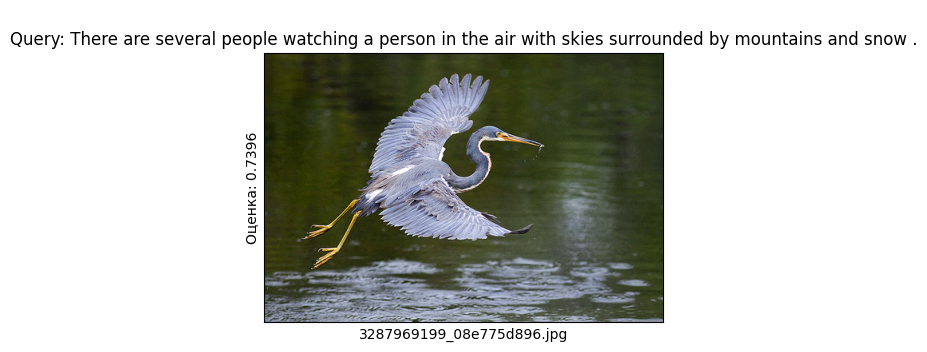

--------------------------------------------------


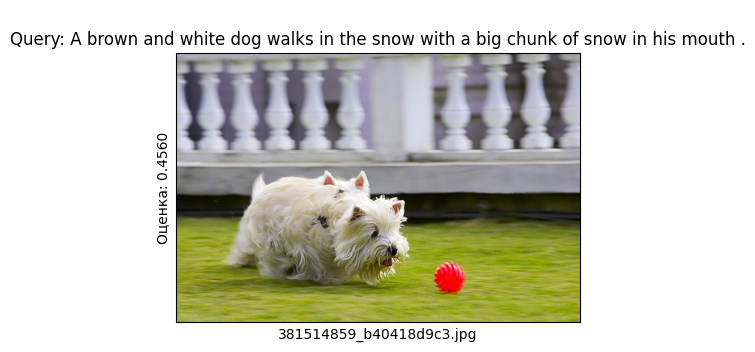

-------------------------------------------------------------------------------------------
Query: "A man and two boys standing in spraying water ." 
 This image is unavailable in your country in compliance with local laws
-------------------------------------------------------------------------------------------
--------------------------------------------------


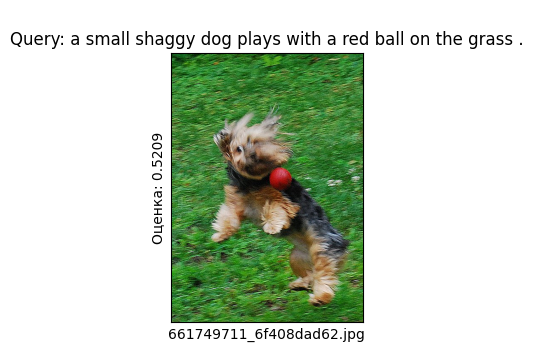

--------------------------------------------------


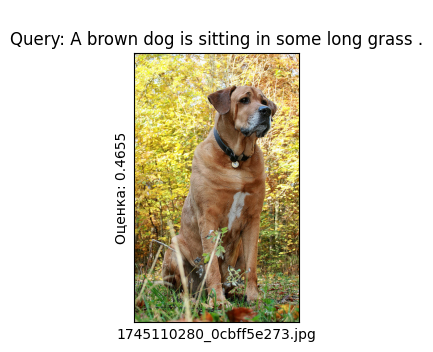

--------------------------------------------------


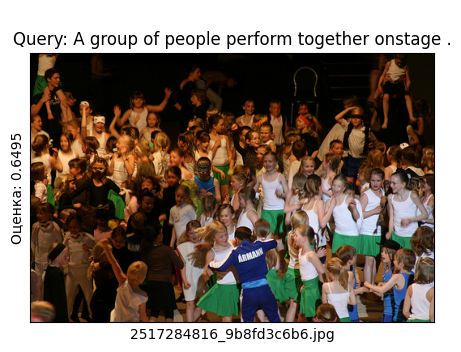

-------------------------------------------------------------------------------------------
Query: "I child slides into a wading pool full of water while an adult tosses a bucket of water on them ." 
 This image is unavailable in your country in compliance with local laws
-------------------------------------------------------------------------------------------
--------------------------------------------------


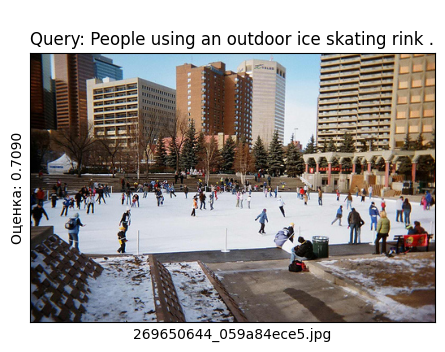

--------------------------------------------------


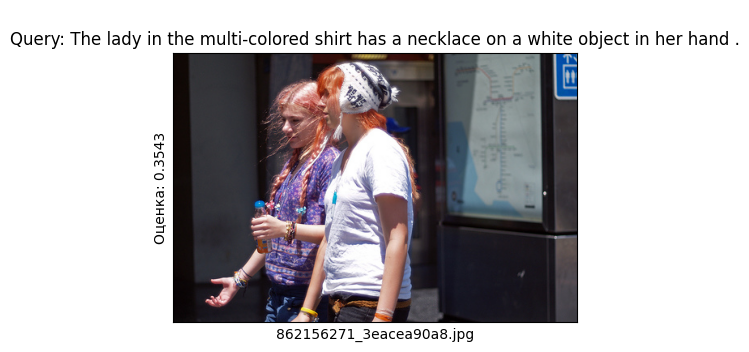

In [51]:
test_model(test_queries, best_nn_model, text_embedder, test_df)

Визуальная оценка результатов предсказания модели на тестовой выборке может считаться удовлетворительной. В более чем половине случаев модель предсказала подходящее изображение, в других случаях изображения подходят только чатично (содержат нужные объекты или элементы контекста).

## Вывод

Несмотря на крайне ограниченные вычислительные ресурсы и небольшой размер тренировочного датасета, нам удалось построить модель, способную делать полностью или частично верные предсказания. На данном этапе модель предсказывает около 40% вариабельности в данных. Если использовать больше тренировочных данных, модель можно значительно улучшить. Несомненно, проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим.